In [58]:
!pip install --upgrade cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.4 MB 2.2 MB/s 


In [3]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc


rc('animation', html='jshtml')

In [59]:
print(cp.__version__)

1.2.1


In [60]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


# Setting and Hyperparameters

In [61]:
valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])

valuations = valuations / np.sum(valuations)

# Load Data

In [63]:
from google.colab import drive
drive.mount('/content/drive')

utility_type = "linear"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_linear = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_linear = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_linear = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_linear = np.load(f)


# utility_type = "leontief"
# coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/coef_hist_{utility_type}_fisher.npy"
# intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/intercept_hist_{utility_type}_fisher.npy"
# values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/values_hist_{utility_type}_fisher.npy"
# budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings/budgets_hist_{utility_type}_fisher.npy"

# with open(coef_hist_filename, 'rb') as f:
#     coef_hist_leontief = np.load(f)
# with open(intercept_hist_filename, 'rb') as f:
#     intercept_hist_leontief = np.load(f)
# with open(values_hist_filename, 'rb') as f:
#     values_hist_leontief = np.load(f)
# with open(budgets_hist_filename, 'rb') as f:
#     budgets_hist_leontief = np.load(f)


utility_type = "cd"
coef_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/coef_hist_{utility_type}_fisher.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/intercept_hist_{utility_type}_fisher.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/values_hist_{utility_type}_fisher.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/jax_savings_big/budgets_hist_{utility_type}_fisher.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_cd = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_cd = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_cd = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_cd = np.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
print(coef_hist_linear[-1])
print(intercept_hist_linear[-1])

print(coef_hist_cd[-1])
print(intercept_hist_cd[-1])

[2.3653286  1.46885294 2.5569754  2.11516402 2.00172939]
843.8263283966813
[0.67352945 0.77522446 0.66792731 0.77625066 0.71893131]
287.8674354338409


# Library

## utilities

In [9]:
val_sum = np.sum(valuations)

In [50]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.prod(np.power(demands, valuations), axis = 1)
    return util

def get_cd_util_single(demand, valuation):
    util = np.prod(np.power(demand, valuation))
    return util
#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )


################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


### JAX

In [11]:
from jax import device_put
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

#### Linear

In [65]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = [savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]]
  return get_linear_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

42.34484
___________________JAX___________________
[[1.100169   1.6552473  0.11626878 1.627147   1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.9271838  1.0227238 ]
 [0.41905752 0.88143325 0.9188884  2.5100925  1.9107077 ]
 [1.320099   2.5682926  0.116973   0.6438177  0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[1.7614986 2.875752  1.9175949 2.3147786 2.2119737]
___________________BY HAND___________________
[[1.100169   1.6552473  0.11626878 1.627147   1.4705926 ]
 [1.5033286  0.40810072 2.5890772  0.9271838  1.0227238 ]
 [0.41905752 0.88143325 0.9188884  2.5100925  1.9107077 ]
 [1.320099   2.5682926  0.116973   0.6438177  0.1438421 ]
 [0.0962974  1.1652519  2.364608   1.5549781  1.5993317 ]]
[1.6354985 2.749752  1.791595  2.1887784 2.0859737]


#### Leontief

In [66]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

251.84608
___________________JAX___________________
[[0.        0.        0.        7.6846156 0.       ]
 [0.        0.        8.325     0.        0.       ]
 [0.        0.        0.        7.6846156 0.       ]
 [0.        4.343478  0.        0.        0.       ]
 [0.        0.        8.325     0.        0.       ]]
[-1.7866192 -2.3563566 -1.5092242 -2.4540308 -1.7832677]
___________________BY HAND___________________
[[11.365527  0.        0.        0.        0.      ]
 [14.337563  0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.       10.095263]
 [ 0.        0.       95.36665   0.        0.      ]
 [ 0.        0.        8.324999  0.        0.      ]]
[-1.9126192 -2.4823565 -1.6352242 -2.580031  -1.9092678]


#### CD

In [67]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils =jnp.prod(jnp.power(demands, valuations), axis= 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  num_buyers = budgets.shape
  next_budgets = jnp.array([savings * ir + jnp.ones(num_buyers) * 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + jnp.sum(jnp.array([discount*(next_budget.T @ value_coef + value_intercept) for next_budget in next_budgets]))/5

prices = device_put(np.array([10.0,10.0, 10.0, 10.0, 10.0]))
demands = device_put(np.array([[2.0,2.1, 1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4],
                               [2.2,2.3,1.2, 1.3, 1.4]]))
budgets = device_put(np.array([10,10,10,10,10]))
savings = device_put(np.array([0.01,0.01,0.01,0.01,0.01]))
value_coef = device_put(np.repeat(1, 5))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

106.33505
___________________JAX___________________
[[0.26363704 0.37776414 0.04643644 0.5998747  0.50343275]
 [0.1074717  0.02790631 0.3393334  0.11217224 0.1148929 ]
 [0.07809733 0.15712556 0.31395453 0.79164714 0.55956614]
 [0.16537674 0.30775654 0.0268655  0.13649294 0.02831709]
 [0.01336996 0.1547498  0.6018885  0.36535832 0.34893832]]
[0.8852626 0.9853089 0.92202   0.9316856 0.9518944]
___________________BY HAND___________________
[[0.22902602 0.32817015 0.04034013 0.52112144 0.43734062]
 [0.10318634 0.02679357 0.32580274 0.10769945 0.11031164]
 [0.07038469 0.14160834 0.2829494  0.7134666  0.50430524]
 [0.15049227 0.2800574  0.02444752 0.12420811 0.02576846]
 [0.01241499 0.14369659 0.55889773 0.33926216 0.3240149 ]]
[0.7592623 0.859309  0.7960199 0.8056856 0.8258944]


## get_max

In [68]:
############# Projection onto affine positive half-space, i.e., budget set ###############
def project_to_bugdet_set(X, p, b):
    X_prec = X
    while (True): 
        X -= ((X @ p - b).clip(min= 0)/(np.linalg.norm(p)**2).clip(min= 0.01) * p)
        X = X.clip(min = 0)
        if(np.linalg.norm(X - X_prec) <= np.sum(X_prec)*0.05):
            break
        # print(f"Current iterate {X}\nPrevious Iterate {X_prec}")
        X_prec = X
    return X

In [69]:
def get_max_linear(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = [ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]]
    obj = cp.Maximize(cp.sum([valuation.T @ allocation + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)

def get_max_leontief(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = np.array([ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    obj = cp.Maximize(cp.sum([cp.min(allocation / valuation) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    saving = saving.value

    return (util, demand, saving)



def get_max_cd(b, valuation, p, gamma, slope, intercept):
    allocation = cp.Variable(p.shape[0])
    saving = cp.Variable()
    next_budgets = np.array([ir*saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    obj = cp.Maximize(cp.sum([valuation.T @ cp.log(allocation) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5)
    constr = [allocation.T @ p  + saving <= b,
                allocation >= 0,
                saving >= 0]
    program = cp.Problem(obj, constr)

    util = program.solve()
    demand = allocation.value
    true_saving = saving.value
    next_budgets = np.array([ir*true_saving + 9.5 for ir in [0.9, 1.0, 1.1, 1.2, 1.5]])
    value = np.sum([get_cd_util_single(demand, valuation) + gamma*(slope*next_budget+intercept) for next_budget in next_budgets])/5
    return (value, demand, true_saving)



In [70]:
b = 10
p = np.array([ 9.00607151,  9.87664057,  9.14926251, 10.18951264,  9.71110442])
gamma = 0.9
slope = 0
intercept = 0

demands = np.array([[0.2146929,  0.23319484, 0.06249327, 0.22090439, 0.22101436],
 [0.26046713, 0.1419532,  0.29355888, 0.15490303, 0.1902244 ],
 [0.13204165, 0.14384679, 0.18333338, 0.2815873,  0.25032915],
 [0.27445656, 0.30765415, 0.16771823, 0.14912222, 0.1231566 ],
 [0.11535447, 0.16933229, 0.28980332, 0.18920852, 0.21162034]])

print(get_max_cd(b, valuations[0], p, gamma, slope, intercept))

print(get_cd_util(demands, valuations)[0])

(0.6664522569976511, array([0.20465648, 0.28074872, 0.02128552, 0.26751238, 0.25367117]), array(4.19981063e-08))
0.6461935933644408


## min-max step

In [71]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  # obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.power(cp.norm(saving - beta), 2))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 1e-3)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)
      # print(demands)
      # print("-----------------------------------------------------")

  next_budgets = savings + np.ones(num_buyers) * 9.5
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("savings:", savings)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

### Test min-max step

2
0.005
[ 9.5498278  10.07485673  9.6644672  10.20537685  9.9928788 ]
[ 9.31132652 10.07055467  9.46230005 10.27242979  9.94200602]
[ 9.18327317 10.03540162  9.34023551 10.27934601  9.88074795]
[ 9.10896437  9.99271205  9.26403423 10.26162695  9.8246721 ]
[ 9.06153779  9.95223843  9.21388062 10.23554853  9.77834351]
[ 9.02870803  9.91731952  9.17898247 10.20848562  9.74165742]
[ 9.00466932  9.88850011  9.15355535 10.18358399  9.71305661]
[ 8.98645876  9.86524347  9.13442115 10.16196363  9.69083449]
[ 8.97238553  9.84669365  9.11971457 10.14380125  9.67353936]

****Min-Max Price Iteration 10****
[ 8.96138953  9.83198583  9.10826688 10.12885033  9.66003434]
[ 8.95274829  9.82035637  9.09929154 10.11670066  9.6494537 ]
Early end! Excess demand norm: 0.009295529405265839
------------------------------------------------------------------
budgets: [ 9.09845395  9.18667045  9.2        10.         10.        ]
demands: [[0.21325154 0.23143359 0.06176616 0.219681   0.21956788]
 [0.24709354 0.12

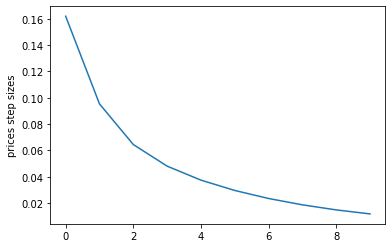

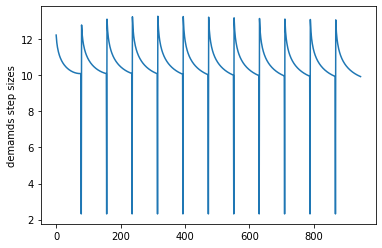

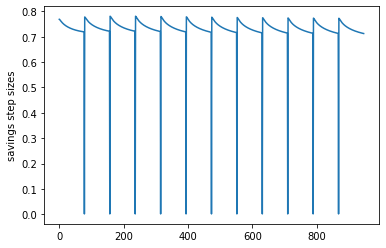

In [72]:
num_goods = 5
num_buyers = 5
num_samples = 25
discount = 0.9

valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])


valuations = valuations / (np.sum(valuations))

learn_rate_prices = 2
learn_rate_demands = 0.005



num_iters_prices = 60
num_iters_demands = 80

value_coef = np.zeros(5)
value_intercept = 0


budgets = np.array([9.09845395, 9.18667045, 9.2, 10, 10])


utility_type = "cd"


print(learn_rate_prices)
print(learn_rate_demands)


prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()


## single_buyer_val_iter

In [73]:
def single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, gamma, slope, intercept, 
                          num_iters, num_samples, utility_type, fitted_value_coef, fitted_value_intercept):
    value_slope_hist = []
    value_intercept_hist = []
    values_hist = []
    budgets_hist = []

    if utility_type == "linear":
        get_max = get_max_linear
    elif utility_type == "leontief":
        get_max = get_max_leontief
    elif utility_type == "cd":
        get_max = get_max_cd

    value_slope = slope
    value_intercept = intercept
    value_slope_hist.append(value_slope)
    value_intercept_hist.append(value_intercept)
    num_buyers = valuations.shape[0]
    

    for iter in range(num_iters):
        print(f"-----------------------Iteration {iter}-------------------")
        values = []
        budget_list = []
        for index, budgets in enumerate(budgets_samples):
          print(f"___sample {index}___")
          value, demand, saving = get_max(budgets[buyer], valuations[buyer], prices_list[index], discount, value_slope, value_intercept)
          values.append(value)
          budget_list.append(budgets[buyer])
          print("buyer value:", value)
          print("buyer demands:", demand)

        values_hist.append(values)    
        budgets_hist.append(budget_list)
        print(budget_list)
        print(values)
        reg = linear_model.LinearRegression()
        reg.fit(np.array(budget_list).reshape(-1,1), np.array(values))
        value_slope = reg.coef_ # Update the slope
        value_intercept = reg.intercept_ # Update the intercept
        
        value_intercept_hist.append(value_intercept)
        value_slope_hist.append(value_slope)
        values_hist.append(values)
        budgets_hist.append(budgets)
        print("SLOPE", value_slope)
        print("INTERCEPT:", value_intercept)
    
    return value_slope, value_intercept, values_hist



## get_greedy_action

In [74]:
def get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands):
  value, prices, demands, savings =  min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False)

  return (prices, demands, savings)

## get_buyers_cumulative_util

In [75]:
def get_buyers_cumulative_util(init_budgets, valuations, utility_type, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters):
  
  if utility_type == "linear":
      get_util = get_linear_util
  elif utility_type == "leontief":
      get_util = get_leontief_util
  elif utility_type == "cd":
      get_util = get_cd_util
  
  num_buyers = valuations.shape[0]
  num_goods = valuations.shape[1]
  cumul_utils = np.zeros(num_buyers)
  excess_demands_hist = []
  budgets = init_budgets   
  for iter in range(num_iters):
    print(f"--------------------cumulative iter {iter}---------------------")
    print(f"budgets: {budgets}")
    prices, demands, savings = get_greedy_action(budgets, valuations, utility_type, value_coef, value_intercept, discount, 
                                           learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands)
    if iter == 0:
      start_prices = prices
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    excess_demands_hist.append(np.linalg.norm(excess_demands))
    print("util:", get_util(demands, valuations))
    cumul_utils += (discount**iter)*get_util(demands, valuations)
    ir = np.random.choice([0.9, 1.0, 1.1, 1.2, 1.5], 1, [0.2, 0.2, 0.2, 0.2, 0.2])
    print("interest rate:", ir)
    print("cumul util:", cumul_utils)
    budgets = ir * savings + np.ones(num_buyers) * 9.5

  return cumul_utils, excess_demands_hist


# Changes in Value Functions

## Plot

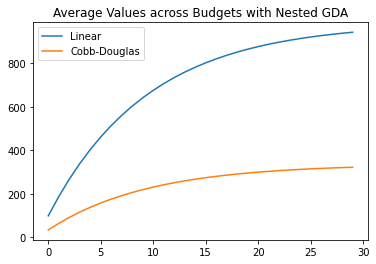

In [76]:
avg_values_linear = np.average(values_hist_linear, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)
# avg_values_leontief = np.average(values_hist_leontief, axis = 1)
# # avg_values_leontief = avg_values_leontief/ np.sum(avg_values_leontief)
avg_values_cd = np.average(values_hist_cd, axis = 1)
# # avg_values_cd= avg_values_cd / np.sum(avg_values_cd)

fig, ax = plt.subplots()
ax.set_title('Average Values across Budgets with Nested GDA')
ax.plot(np.arange(0, avg_values_linear.shape[0]), avg_values_linear, label = "Linear")
# ax.plot(np.arange(0, avg_values_leontief.shape[0]), avg_values_leontief, label = "Leontief")
ax.plot(np.arange(0, avg_values_cd.shape[0]), avg_values_cd, label = "Cobb-Douglas")
ax.legend()
fig.show()


# Distance to Utility Maximization

## Single_buyer_val_iter

In [77]:
valuations = np.array([[0.50722067, 0.76313337, 0.05360443, 0.7501781,  0.67800042],
 [0.2274455,  0.06174344, 0.39171342, 0.1402779,  0.15473259],
 [0.16527965, 0.3476444,  0.36241701, 0.99000073, 0.75359852],
 [0.34999164, 0.68091931, 0.0310125,  0.17069236, 0.03813618],
 [0.02829523, 0.34238797, 0.69479688, 0.45690191, 0.4699344 ]])


valuations = valuations / (np.sum(valuations))

discount = 0.9

slope = 0
intercept = 0

num_iters = 50
num_samples = 15
utility_type = "cd"


budgets = np.array([10,10])
fitted_value_coef = coef_hist_cd[-1]
fitted_value_intercept = intercept_hist_cd[-1]
# fitted_value_coef = np.array([0.67354101, 0.77528279, 0.66791171, 0.77624322, 0.71894623])
# fitted_value_intercept = 260
print(fitted_value_coef)
print(fitted_value_intercept)

num_iters_prices = 60
num_iters_demands = 80


[0.67352945 0.77522446 0.66792731 0.77625066 0.71893131]
287.8674354338409


##### Get budgets-prices pairs for value iterations

In [78]:
num_buyers = valuations.shape[0]
budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
prices_list = []
learn_rate_prices = 2
learn_rate_demands = 0.005
for index, budgets in enumerate(budgets_samples):
    print(f"-------------------------Sample {index}--------------------------------")
    min_max_value, prices, demands, savings = min_max_linear_value_jax(budgets, valuations, fitted_value_coef, fitted_value_intercept, discount, 
                                                                      learn_rate_prices, learn_rate_demands,
                                                                      num_iters_prices, num_iters_demands, utility_type, test=False)
    prices_list.append(prices)

print(prices_list)

-------------------------Sample 0--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.00926022096910732
------------------------------------------------------------------
budgets: [9.32370608 9.47804161 9.30780362 9.77705795 9.19757998]
demands: [[0.21959655 0.23787146 0.06917243 0.22561537 0.22589017]
 [0.25414768 0.13762549 0.28677257 0.15081425 0.18526683]
 [0.13013918 0.14156866 0.18075206 0.27708879 0.24625991]
 [0.27647701 0.30945556 0.1716234  0.15276766 0.12761292]
 [0.11624609 0.16894187 0.28818933 0.18875424 0.21086263]]
savings: [0.0657295  0.06528403 0.06449169 0.06618443 0.06590253]
prices: [8.83419143 9.67322838 8.96630899 9.96632085 9.51016878]
value: 323.34415
excess demands: [-0.00339348 -0.00453696 -0.00349021 -0.00495969 -0.00410754]
-------------------------Sample 1--------------------------------

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.008064461758846212
----------------------------------

##### Single buyer value iteration

In [79]:
slope = 0
intercept = 0
learned_slopes = []
learned_intercepts = []
cumul_utils_single = []
values_hists = []

for buyer in range(num_buyers):
  opt_value_slope, opt_value_intercept, values_hist = single_buyer_val_iter(budgets_samples, prices_list, buyer, valuations, discount, slope, intercept, num_iters, num_samples, 
                                                                                            utility_type, fitted_value_coef, fitted_value_intercept)
  print(f"cumul util: {opt_value_slope * budgets[buyer-1] + opt_value_intercept}")
  print(f"slope: {opt_value_slope}")
  print(f"intercept: {opt_value_intercept}")
  cumul_utils_single.append(opt_value_slope * budgets[buyer-1] + opt_value_intercept)
  values_hists.append(values_hist)
  learned_slopes.append(opt_value_slope)
  learned_intercepts.append(opt_value_intercept)

Streaming output truncated to the last 5000 lines.
buyer demands: [0.29553398 0.5247553  0.02578557 0.12762619 0.02990018]
___sample 2___
buyer value: 0.8617044282227088
buyer demands: [0.30346878 0.53890853 0.02650059 0.13120295 0.0307295 ]
___sample 3___
buyer value: 0.8553311985219125
buyer demands: [0.28699611 0.50962406 0.02504306 0.12386243 0.02902116]
___sample 4___
buyer value: 0.8576132545658762
buyer demands: [0.29273023 0.52014007 0.02555585 0.12634207 0.02960715]
___sample 5___
buyer value: 0.859482135422858
buyer demands: [0.29730767 0.52874445 0.02596505 0.12870479 0.03012517]
___sample 6___
buyer value: 0.8548761622467049
buyer demands: [0.28563593 0.5077112  0.02493638 0.12342525 0.02890368]
___sample 7___
buyer value: 0.8578897715652923
buyer demands: [0.29307024 0.5216212  0.02558257 0.12680461 0.02968441]
___sample 8___
buyer value: 0.8581212628365883
buyer demands: [0.29396186 0.52259106 0.02565327 0.12689056 0.0297339 ]
___sample 9___
buyer value: 0.857386530772957

##### Cumulative utils single

[6.55677089 8.60745981 6.67939762 8.5407951  7.42703451]


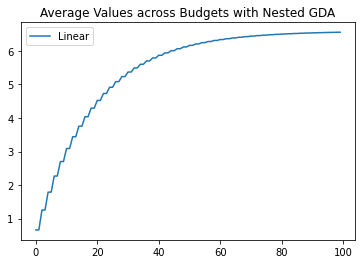

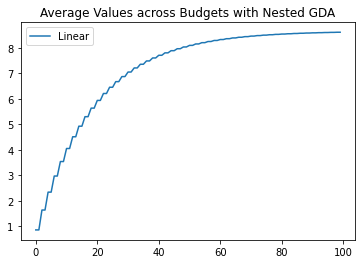

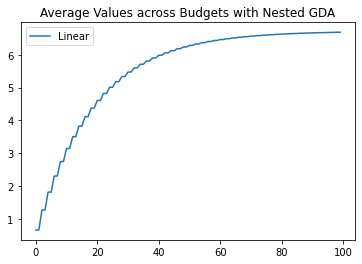

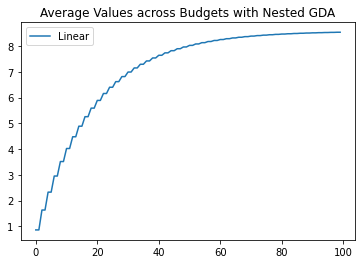

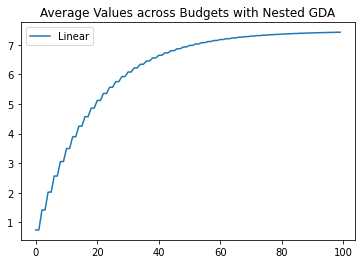

In [80]:
single_cumul_utils = np.array([util[0] for util in cumul_utils_single])
print(single_cumul_utils)

for values_hist in values_hists:
  avg_values = np.average(values_hist, axis = 1) 
# avg_values_linear = avg_values_linear / np.sum(avg_values_linear)


  fig, ax = plt.subplots()
  ax.set_title('Average Values across Budgets with Nested GDA')
  ax.plot(np.arange(0, avg_values.shape[0]), avg_values, label = "Linear")
  ax.legend()
  fig.show()

## Cumul_util all buyers

In [81]:
init_budgets = np.ones(num_buyers) * 10.0
print(fitted_value_coef)
print(fitted_value_intercept)
num_iters_prices = 60
num_iters_demands = 80
num_iters = 50
discount = 0.9
learn_rate_prices = 2
learn_rate_demands = 0.005
utility_type = "cd"
cumul_utils, excess_demands_hist =  get_buyers_cumulative_util(init_budgets, valuations, utility_type, fitted_value_coef, fitted_value_intercept, discount, learn_rate_prices, learn_rate_demands,
                               num_iters_prices, num_iters_demands, num_iters)

[0.67352945 0.77522446 0.66792731 0.77625066 0.71893131]
287.8674354338409
--------------------cumulative iter 0---------------------
budgets: [10. 10. 10. 10. 10.]
Early end! Excess demand norm: 0.008407964935650424
------------------------------------------------------------------
budgets: [10. 10. 10. 10. 10.]
demands: [[0.22286993 0.24247623 0.06456258 0.23030406 0.22956022]
 [0.25540527 0.13402895 0.28905823 0.14945155 0.18336589]
 [0.12931491 0.14273554 0.18220858 0.28386272 0.25092339]
 [0.27189255 0.30612989 0.16217523 0.14583249 0.11609624]
 [0.1162792  0.17340311 0.29734614 0.1948253  0.2166886 ]]
savings: [0.0654498  0.06534341 0.06418786 0.06652718 0.06551085]
prices: [ 9.33716076 10.26305491  9.49021376 10.57396381 10.09359813]
value: 325.32663
excess demands: [-0.00423814 -0.00122627 -0.00464925  0.00427612 -0.00336566]
util: [0.65346076 0.85996576 0.66500563 0.83533945 0.73418249]
interest rate: [1.1]
cumul util: [0.65346076 0.85996576 0.66500563 0.83533945 0.73418249]
-

In [82]:
print(excess_demands_hist)
print(np.mean(excess_demands_hist))

[0.008407964935650424, 0.008967146064141155, 0.009083158245098727, 0.008966238767543195, 0.00920136891554679, 0.008966200875335046, 0.009083143044466589, 0.008966227733211514, 0.00908315884134709, 0.008845970722471338, 0.009201463558288818, 0.009201412894529372, 0.008489945860468435, 0.009083337842561408, 0.009201349908232728, 0.00884595231448397, 0.00884598520682012, 0.008490031684566695, 0.008846087731171575, 0.00908326892205459, 0.008489975507842704, 0.008846082716398581, 0.009201478083188178, 0.008489937500523105, 0.008846088638968854, 0.009201469934615758, 0.008489945749222006, 0.009083330216050652, 0.009201448454749548, 0.008966196157272887, 0.008966071047717258, 0.008966130130388127, 0.008966107816085834, 0.009201255487288923, 0.008489943694149186, 0.009083330486075061, 0.009083231866534846, 0.009083223927931821, 0.00908323948915755, 0.008966230053185963, 0.009083142859353426, 0.009201445127410236, 0.008845920658672506, 0.009083276029682468, 0.008845952589135685, 0.0090832880752

In [83]:
print(cumul_utils)

[6.49143036 8.55163396 6.60808333 8.30177354 7.29588985]


## Results

In [84]:
print(cumul_utils)
print(single_cumul_utils)

[6.49143036 8.55163396 6.60808333 8.30177354 7.29588985]
[6.55677089 8.60745981 6.67939762 8.5407951  7.42703451]


In [85]:
print(np.linalg.norm(cumul_utils-single_cumul_utils))
print(np.linalg.norm(cumul_utils-single_cumul_utils) / np.linalg.norm(single_cumul_utils))

0.2946215633245951
0.017306743257830867
